In [178]:
#Import of all the necessary packages

import numpy as np
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm # Progress bar for loops
import networkx as nx # Tools to construct graphs and sample adjacency matrices
import scipy
import os # To save the arrays we create


In [269]:
# Definition of the variables for our system

# Hyperparameters
d = 10**2  # Dimension of our system
alpha = 10**2 # Inverse strength of the regularizer in our loss function
sigma = 10**0  # Variance of the noise sampled
time = 10  # Study the evolution of our model for 'time' timesteps
beta = 1  # Number of measures taken between each timestep for smooth visualization
taverage = 2 * 10**3 # Number of iterations averaged for the autocorrelation matrix

# NetworkX parameters
Nedges = 1.4  # Average number of edges leaving a node


In [270]:
#Usage of the package Networkx 

    #Sampling on a Erdos-Rényi graph. We add a random weight between 0 and 1 to every edge we created. Then, we check the eigenvalues of the adjacency matrix and rescale it so that the spectral radius is smaller than 1, implying a convergence in our model.
def weightedsampling(d, Nedges, drawing="no"):
    p = Nedges / d  # Calculate edge creation probability
    print("sampling of the graph")
    
    G = nx.erdos_renyi_graph(d, p, directed=True) # Generate Erdős-Rényi graph
    
    for u, v in G.edges():
        G.edges[u, v]['weight'] = random.uniform(0.1, 1.0) # Assign random weights to edges
    
    R = nx.to_numpy_array(G) # Convert graph to adjacency matrix

    eigenvalues = np.linalg.eigvals(R)
    R = 0.9/max(np.absolute(eigenvalues)) * R #Set the spectral radius to 0.9
    
    # Reconstruct graph if required
    if drawing == "no":
        G_reconstructed = np.identity(d)
    else:
        G_reconstructed = nx.from_numpy_array(R, create_using=nx.DiGraph)
    
    print(G)
    return R, G_reconstructed

    #Drawing of the graph. The small links do not get drawn.    
def drawing(G, pos='helper', ax=None, node_size=800, node_color='skyblue', font_size=10, font_color='black', edge_color='gray', edge_width=2.5, edge_alpha=0.8, threshold=0.02):
    spread_factor = 10 # just for the graph to look better :-)
    if pos == 'helper':  # Generate positions of the nodes in the graph if not provided
        pos = nx.spring_layout(G, k=spread_factor / np.sqrt(len(G.nodes())))
    
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors='black', linewidths=1, ax=ax) # Draw nodes with customizations
    
    for u, v, d in G.edges(data=True):
        if abs(d['weight']) > threshold:  # Draw edges only if the weight is above the threshold
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_width, edge_color=edge_color, alpha=edge_alpha, arrows=True, arrowsize=15, ax=ax)
            nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): "{:.2f}".format(d['weight'])}, font_size=font_size, font_color=font_color, ax=ax)
    
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_color=font_color, ax=ax)     # Draw node labels
    
    # Adjust plot margins for better spacing
    #ax.margins(0.1, 0.1)
    
    ax.axis('off') #remove axis
    
    return pos

In [271]:
#Useful functions that we will use in the following

    #We want the process to be smoother, thus we defined the parameter beta which accounts the number of measures we do between two instance of time in the underlying process. We so have to rescale the adjacency matrix. This can be seen as a damping
def newR(R, d, beta):
    #X_{t+1} = (1 - 1/beta)* Id * X_t + 1/beta * f(X_t) generates X_{t+1} = [(1- 1/beta) * Id + A / \beta] X_t + \sigma / \beta \xi_t
    return((1-1/beta)* np.identity(d) + R/beta)

    #list of power of a matrix
def power(R,time,d):
    listpower = np.zeros((time,d,d))
    listpower[0] = np.identity(d)
    for i in range(1,time) :
        listpower[i] = listpower[i-1] @ R
    return(listpower)

    #list of sum of the power of the matrix squared, the i'th elem should be R**2+R**4+...+R**2i. This is used in the evaluation of the variance term in the theoretical response.
def sumpower(R,time,d):
    sumpower = np.zeros((time,d,d))
    listpower = power(R,time,d)
    sumpower[0] = np.identity(d)
    for i in range(1,len(listpower)):
        sumpower[i] = sumpower[i-1] + listpower[i] @ np.transpose(listpower[i])
    return(sumpower,listpower)

    #discrete Lyapunov equation solution in order to compute theoretically C0.
def solvediscretelyapunov(A, sigma, beta, tol=1e-15, max_iter=1000):
    # Ensure A is a numpy array
    A = np.array(A)
    A0 = A
    X = np.zeros_like(A)
    current_sum = np.identity(len(A[0]))
    
    for k in range(max_iter):
        term =  A @ A.T
        A = A @ A0
        current_sum += term
        if np.linalg.norm(term, ord='fro') < tol:
            print("Number of term in the sum to compute C0 =",k)
            break
    X = sigma **2 / beta**2 *current_sum
    return X

    #theoretical autocorrelation matrices of the vector autoregressive model of order 1
def theoreticalcovariance(R,time,d, sigma, beta):
    Cth= np.zeros((beta * time,d,d))
    Cth[0] = solvediscretelyapunov(R, sigma, beta)
    for i in range(1,beta * time):
        Cth[i] = R @ Cth[i-1]
    return(Cth)

    #autocorrelation time of the underlying process. We also compute the effective sampling size due to the residual correlations between variables.
def autocorrelationtime(Cth,time, beta, max_iter = 1000, tol = 10**-15):
    print("Computation of the autocorrelation time of our process")
    lambdamaxlist = []
    sumautocorr = 0
    lambdamaxlist.append(np.real(max(np.linalg.eigvals(Cth[0]))))
    threshold = lambdamaxlist[0]/np.exp(1)
    
    for i in range(1,beta * time):
        lambdamaxlist.append(np.real(max(np.linalg.eigvals(Cth[i]))))
        if threshold < lambdamaxlist[i-1] and threshold > lambdamaxlist[i]:
            autocorrtime = i
            break
    print("Autocorrelation time of the process=", autocorrtime)
    f= lambda x : lambdamaxlist[0] * np.exp(- x/autocorrtime) #fitted autocorrelation function. We tend to overestime tau, meaning that the decay of the distribution is slower. This induces a smaller effective sampling size. see https://andrewcharlesjones.github.io/journal/21-effective-sample-size.html
    
    for k in range(max_iter):
        addedterm = f(k * autocorrtime)/lambdamaxlist[0]
        sumautocorr+= addedterm
        if addedterm < tol :
            break
    print("due to correlations, the sample size has to be divided by", sumautocorr)
    return(autocorrtime, sumautocorr)
    
    #convergence of our system to an attractor. We do not use the discretization scheme introduced and do big steps.
def convergence(R, sigma, beta, d, tconvergence = 10**5):
    X0=np.random.normal(0, sigma, size=(d,1))
    for j in tqdm(range(beta * tconvergence)):
        xi=np.random.normal(0, sigma, size=(d,1))
        X0 = R @ X0 + xi
    return(X0)
    
    #Computation of the sample
def computationX(X,smallR,xi,taverage,time, beta):
    for j in tqdm(range(1,taverage * beta)):
        X[j,:,:] = smallR @ X[j-1,:,:] + 1/beta * xi[j-1,:,:]        
    return(X)
    
    #Computation of empirical correlation matrices
def computationCt(X,xi, taverage, time, autocorrtime, beta):
    i = 0
    Ct = np.zeros((beta * time,d,d))
    for j in tqdm(range(beta * (taverage-time) -1 )):
        if j % autocorrtime ==0:
            i+=1
            for t in range(0,beta * time):
                Ct[t,:,:] += X[j+t,:,:] @ np.transpose(X[j,:,:])
    print("# of measures for Ct :", i)
    return(Ct, i)

    #save the adjacency matrix and the measures we found, don't forget to put the good directory.
def saving(X, R, d, Nedges, taverage, beta, base_directory=r"C:\Users\marchetta\Desktop\Stage\Results"):
    directory_name = f"matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}_measures_between_two_ts={beta}"
    full_directory_path = os.path.join(base_directory, directory_name)
    if not os.path.exists(full_directory_path):
        os.makedirs(full_directory_path)
    Xfilename = f"sample_of_matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}.npy"
    Rfilename = f"matrix_of_matrixsize={d}_averageconnectivity={Nedges}.npy"
    xifilename = f"noise_of_matrixsize={d}_averageconnectivity={Nedges}.npy"
    Xfile_path = os.path.join(full_directory_path,Xfilename)
    Rfile_path = os.path.join(full_directory_path,Rfilename)
    xifile_path = os.path.join(full_directory_path,xifilename)
    np.savez_compressed(Xfile_path, X)
    np.savez_compressed(Rfile_path,R)
    np.savez_compressed(xifile_path,R)

    #This is a technical function, allowing us to unpack our data stored in npz format in a good way.
def load_array(file_path):
    with np.load(file_path) as data:
        array = data['arr_0']
    return array
    
    #Load data generated previously. Don't forget to put the good base directory
def loaddata(d, Nedges, taverage, beta, base_directory=r"C:\Users\marchetta\Desktop\Stage\Results"):
    directory_name = f"matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}_measures_between_two_ts={beta}"
    full_directory_path = os.path.join(base_directory, directory_name)
    
    Xfile_path = os.path.join(full_directory_path, f"sample_of_matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}.npy.npz")
    Rfile_path = os.path.join(full_directory_path, f"matrix_of_matrixsize={d}_averageconnectivity={Nedges}.npy.npz")
    xifile_path = os.path.join(full_directory_path, f"noise_of_matrixsize={d}_averageconnectivity={Nedges}.npy.npz")
    
    X = load_array(Xfile_path)
    R = load_array(Rfile_path)
    xi = load_array(xifile_path)
    return(X, R, xi)

In [272]:
#Composed function that either import the data and the graph to compute the empirical correlation matrices, or iterate the process from scratch, by first sampling a graph.

def process(d, Nedges, alpha,time, taverage, sigma, beta, load = "no", withsave = "no", drawing = "no"):
    
    #Construction of our arrays and convergence to an attractor of the system.
    
    if load == "no":
        X = np.zeros((beta * taverage, d, 1))
        C0=np.zeros((1,d,d))
        xi = np.random.normal(0, sigma, size=(beta * taverage, d,1))
        R, G_reconstructed = weightedsampling(d, Nedges, drawing)
        #R = np.array([[0,0,0.9],[0,0,0],[0,0,0]])
        smallR = newR(R, d, beta)
        print("Convergence to a fixed point")
        X[0,:] = convergence(R, sigma, beta, d) #convergence is set to 10**5, which is a big value because first moment was already good for X.
        print("Computation of the process")
        X = computationX(X,smallR,xi,taverage,time, beta)
        
    else:
        print("Import of the data")
        X, R, xi = loaddata(d, Nedges, taverage, beta)
        if drawing == "no":
            G_reconstructed = np.identity(d)
        else:
            G_reconstructed = nx.from_numpy_array(R, create_using=nx.DiGraph)
        print("Data imported")
        
    # iteration of the process and computation of Ct for each t. We average over taverage realisations.
    
    print("Computation of the theoretical autocorrelation matrix")
    Cth = theoreticalcovariance(smallR,20,d, sigma, beta) # 20 for the max time of computation of Cth is arbitrary, it is just so that we find a good autocorrelation time in the following. Right after, we truncate it to what we need. Moreover, since we rescaled R so that it has a spectral radius of 0.9, we expect the autocorrelation time to be around 10 * beta.
    autocorrtime, ratioeffectivesamplesize = autocorrelationtime(Cth, 20, beta) #measures are correlated so we have to look at the characteristic time of correlation of the system, which is linked to the EV of the population matrix. We still have some correlations so we also compute the effective number of measures.
    Cth = Cth[:beta * time,:,:]
    
    print("Computation of Ct")
    Ct, Neff = computationCt( X,xi, taverage, time, autocorrtime, beta)
    Neffunco = Neff/ ratioeffectivesamplesize #Note that we still have some correlations in our process and we rescale it after so that this is the number of totally uncorrelated measures.
    print("Neff=", Neff)
    Ct=Ct/Neff
    Rt = np.zeros((beta * time, d, d))
    for i in range(beta * time):
        Rt[i,:,:] = alpha * Ct[i,:,:] @ np.linalg.inv(np.identity(d)+ alpha * Ct[0,:,:])
        
    #save the dataset    
    
    if withsave != "no" and load =="no": #We save in NPZ format, which is a compressed format for numpy arrays. It gives at least one less order of magnitude for the memory we have to use.
        print("Doing the save")
        saving(X, R, d, Nedges, taverage, beta)
        print("Save successfully done")
    return(Rt, Ct, Cth ,X , autocorrtime, R, G_reconstructed, Neff, Neffunco)

In [273]:
# Plot of sampled Erdos-Renyi graph, and the inferred one.

def drawing_of_process(Rt, Ct, Cth, R, G_reconstructed, alpha, beta, ax):
    print(G_reconstructed)
    Rinfered = ((1/beta -1) * np.identity(len(Rt[1,0,:])) + Rt[1,:,:]) * beta
    Ginfered = nx.from_numpy_array(Rinfered, create_using=nx.DiGraph)
    print(Ginfered)
    count = 0
    for u, v, d in Ginfered.edges(data=True):
        if d['weight'] > beta * 0.02:
            count += 1
            
    print("Number of edges plotted =",count)
    print("Drawing of the true response")
    pos = drawing(G_reconstructed, ax=ax[0])
    print("Drawing of the difference between the true response matrix and the inferred one")
    G_reconstructedar = nx.to_numpy_array(G_reconstructed)
    diff = G_reconstructedar - Rinfered
    diffG = nx.from_numpy_array(diff, create_using=nx.DiGraph)
    pos = drawing(diffG, pos, ax=ax[1])
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    #plt.savefig(f'graph_alpha_{alpha}.png')
    plt.show()



In [274]:
#Construction of the theoretical response function using random matrix theory

    #Construction of the deterministic equivalent using the empirical correlation matrix we found above

        #self-energy of the system

def selfenergy(h, alpha):
    return alpha / (1 + h)

def dlambda_dalpha(alpha,selfe,rho,Q):
    
    # \frac{\partial \Lambda}{_partial \alpha} = \Lambda^2 / \alpha ^2 * \rho /( \rho - Q[\Lambda])
    
    return( selfe**2/alpha**2 *rho/(rho -Q))

    #bias term
def compute_bias(Rlistpower,G, time, alpha,d):
    helperbias = np.zeros((time,d,d))
    bias = np.zeros((time,d,d))
    print("Computation of the bias term")
    for t in range(time):
        helperbias[t] = Rlistpower[t] @ (np.identity(d) - G)
    for t in tqdm(range(0,time)):
        for i in range(d):
            for j in range(d):
                bias[t,i,j] = helperbias[t,i,j] * helperbias[t,i,j]
    return(bias)

    #variance term
def compute_variance(Rsumpower, G, time, d):
    variance = np.zeros((time,d,d))
    helper = G @ (np.identity(d)-G)
    print("Computation of the variance term")
    for t in tqdm(range(time)):
        if t == 0 :
            variance[t,:,:] = 0
        else :
            for i in range(d):
                    for j in range(d):
                        variance[t,i,j] = Rsumpower[t-1,i,i] * helper [j,j]
    return(variance)
                
        #fixed point iteration in order to find the renormalized coefficient alpha
    
def fixed_point_iteration(Cth, rho, alpha, initial_guess, tol, max_iter):
    eigenvalues = np.real(np.linalg.eigvals(Cth))
    listh=[]
    h_new = initial_guess
    listh.append(h_new)
    for ts in range(max_iter): # iteration of the self convergence
        h_old = copy.deepcopy(h_new)
        selfe = selfenergy(h_old, alpha) 
        h_new = 0
        for eigenvalue in eigenvalues :
            h_new += alpha/(rho * len(eigenvalues)) * eigenvalue * (1+ selfenergy(h_old,alpha) * eigenvalue)**(-1)
        if abs(h_new - h_old) < tol:
            selfe = selfenergy(h_new, alpha) 
            print("h final =",h_new)
            print("selfenergy =", selfe)
            print("ratio self-energy / alpha =", selfe/alpha)
            return selfe, h_new
        listh.append(h_new)
    selfe = selfenergy(h_new, alpha)
    print("Warning: Maximum number of iterations reached.")
    print("h final =",h_new)
    print("selfenergy =", selfe)
    print("Ratio self-energy / alpha =", selfe/alpha)
    return selfe, h_new
        
    #resolvent-like quantity
    
def resolvent(C,alpha,d) :
    return(np.linalg.inv(np.identity(d) + alpha * C))

        #theoretical formula
def RMTempiricalresponse(Cth, R, rho, alpha, time, Neff, d, sigma, beta, initial_guess = alpha/10000, tol=1e-15, max_iter=10000):
    smallR = newR(R,d, beta)
    print("Computation of the theoretical covariance")
    Rsumpower, Rlistpower = sumpower(smallR,beta * time,d)
    helperbias = np.zeros((beta * time,d,d))
    bias = np.zeros((beta * time,d,d))
    variance = np.zeros((beta * time,d,d))
    print("Fixed point convergence")
    selfe, g, spectrum = solve_fp_eq(Cth[0], alpha, rho, initial_guess, tol, max_iter)
    print("Computation of bias and variance term")
    print('renormalized alpha=',selfe)
    G = resolvent(Cth[0], selfe,d)
    bias = compute_bias(Rlistpower,G, beta * time, alpha,d)
    variance = compute_variance(Rsumpower, G, beta * time, d)
    Q = Q_lambda (spectrum, selfe)
    dl = dlambda_dalpha(alpha,selfe,rho,Q)
    variance =   dl * sigma**2 * alpha / (beta**2 * Neff) * variance 
    RTrmt = bias + variance
    return (RTrmt, bias, variance)

#this formula is the one without going to the random matrix formalism.
#def RMTempiricalresponseBIS(Ct, R, alpha, time, Neff, d, sigma = 1):
#    print("Computation of the theoretical covariance")
#    Rsumpower, Rlistpower = sumpower(R,time,d)
#    helperbias = np.zeros((time,d,d))
#    bias = np.zeros((time,d,d))
#    variance = np.zeros((time,d,d))
#    print("Computation of bias and variance term")
#    G = resolvent(Ct[0], alpha,d)
#    bias = compute_bias(Rlistpower,G, time, alpha,d)
#    variance = compute_variance(Rsumpower, G, time, d)
#    variance = alpha * sigma / Neff * variance 
#    RTrmt = bias + variance
#    return (RTrmt, bias, variance)


g final = 0.013852037204783025
selfenergy = 45.5166871383858
ratio self-energy / alpha = 0.455166871383858
Q= 0.9725498256912005
G [[ 1.32912642e-02  5.81878220e-05  6.39814228e-05 ...  4.02721314e-05
   0.00000000e+00  3.03935302e-05]
 [ 5.81878220e-05  7.88664902e-03  4.06422456e-05 ... -4.39271292e-04
   0.00000000e+00  3.53024399e-05]
 [ 6.39814228e-05  4.06422456e-05  1.32031009e-02 ...  3.53002987e-05
   0.00000000e+00 -2.53004392e-03]
 ...
 [ 4.02721314e-05 -4.39271292e-04  3.53002987e-05 ...  1.67617547e-02
   0.00000000e+00  3.48463907e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.14976616e-02  0.00000000e+00]
 [ 3.03935302e-05  3.53024399e-05 -2.53004392e-03 ...  3.48463907e-05
   0.00000000e+00  1.83925843e-02]]
G^2 [[ 2.56649336e-04  1.01389808e-06  1.23418299e-06 ...  1.21561747e-06
   0.00000000e+00  1.28423039e-07]
 [ 1.01389808e-06  6.41402427e-05  5.50092745e-07 ... -8.92040703e-06
   0.00000000e+00  3.73814337e-07]
 [ 1.23418299e-06  

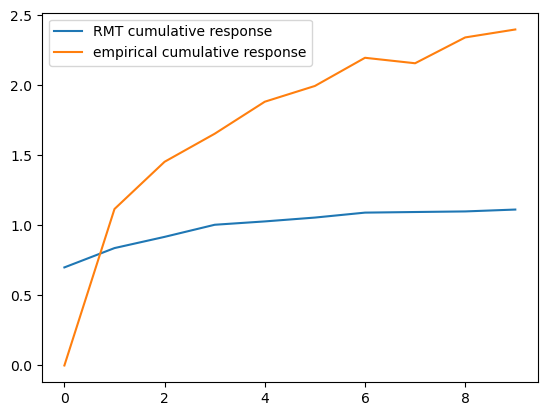

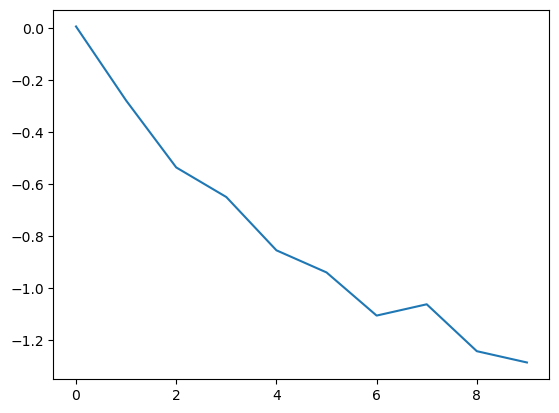

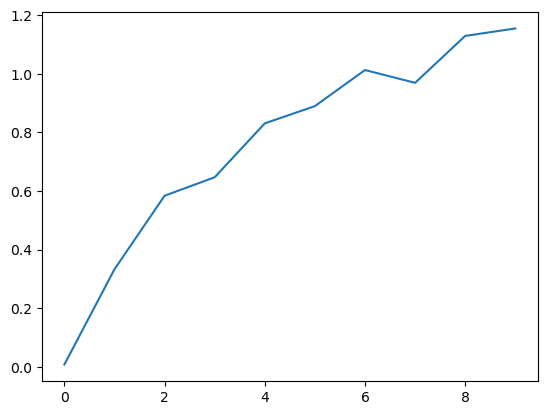

In [297]:
def solve_fp_eq(C0th, alpha, rho, initial_guess, tol, max_iter):
    # \lambda = \alpha * (1- 1/\rho) + \alpha / \rho * g[\lambda]
    # g = \int dx \nu_{\infty}(x) * (1+ \lambda * x)^{-1}
    
    selfe_old = initial_guess
    g_old = 0
    eigen = np.real(np.linalg.eigvals(C0th)) #real because population matrix is symmetric
    for i in range(max_iter):
        g_new = 0
        for eig in eigen :
            g_new += 1/len(eigen) * 1/(1+ selfe_old * eig)
        selfe_new = alpha * ( 1- 1/rho + g_new/rho)
        #print(selfe)
        if abs(selfe_new - selfe_old) < tol:
            print("g final =",g_new)
            print("selfenergy =", selfe_new)
            print("ratio self-energy / alpha =", selfe_new/alpha)
            return selfe_new, g_new, eigen
        selfe_old = selfe_new

#solve_fp_eq(Cth[0], alpha, Neff/d)
        
def Q_lambda (eigen, selfe):
    
    # Q(\lambda) = 1 - 2g [\lambda] + g_2 [\lambda]
    # g_k = \int dx \nu_{\infty}(x) * (1+ \lambda * x ) ^{-k}
    
    g1 = 0
    g2 = 0
    for eig in eigen :
        g1 += 1/len(eigen) * 1/(1+ selfe * eig)
        g2 += 1/len(eigen) * 1/(1+selfe*eig)**2
    Q = 1 - 2 * g1 + g2
    print("Q=", Q)
    return Q

def dlambda_dalpha(alpha,selfe,rho,Q):
    
    # \frac{\partial \Lambda}{_partial \alpha} = \Lambda^2 / \alpha ^2 * \rho /( \rho - Q[\Lambda])
    
    return( selfe**2/alpha**2 *rho/(rho -Q))


def RMTempiricalresponse_full(Cth, R, rho, alpha, beta, Neff, d, time, sigma, initial_guess = None , tol = 10**-12 , max_iter = 10**4):
    if initial_guess is None:
        initial_guess = alpha / 1000
        
    fullresponse = np.zeros((beta*time,))
    bias = np.zeros((beta*time,))
    variance = np.zeros((beta * time,))
    
    smallR = newR(R,d, beta)
    selfe, g, spectrum = solve_fp_eq(Cth[0], alpha, rho, initial_guess, tol, max_iter)
    Q = Q_lambda(spectrum, selfe)
    G = resolvent(Cth[0], selfe,d)
    print('G',G)
    print('G^2', G @ G)
    print('G - G^2', G - G @ G)
    print( "np.trace(  (np.identity(d) -G) @ G)", np.trace(  (np.identity(d) -G) @ G))
    print("np.trace( G @ (np.identity(d) -G))", np.trace( G @ (np.identity(d) -G)))
    Rsumpower, Rlistpower = sumpower(smallR,beta * time,d)
    dl = dlambda_dalpha(alpha,selfe,rho,Q)
    print('dl=', dl)
    for t in range(beta*time):
        #print(Rsumpower[t])
        TrAAt = np.trace(Rlistpower[t] @ np.transpose(Rlistpower[t]))
        bias1 = TrAAt
        bias2 = - np.trace(Rlistpower[t] @ G @ np.transpose(Rlistpower[t]))
        bias3 =  - dl * np.trace (Rlistpower[t] @ G @ (np.identity(d) -G) @ np.transpose(Rlistpower[t]) )
        #bias2 = 0
        #bias3 = 0
        bias[t] = bias1 + bias2 + bias3
        print("biastot =",bias[t])
        if t == 0 :
            variance[t] = 0
        else:
            variance[t] = dl * np.trace(  (np.identity(d) -G) @ G) * np.trace(Rsumpower[t-1])
        print("t=",t)
        print("bias1=",bias1)
        print("bias2=",bias2)
        print("bias3=",bias3)
        print("variance",variance[t])
    variance =  alpha * sigma **2 / Neff  * variance
    print("prefactor =", alpha * sigma **2/ Neff)
    bias, variance = bias /(Nedges * d), variance / (Nedges*d) 
    response = bias + variance
    return(response,bias,variance)


response, cumbias, cumvariance = RMTempiricalresponse_full(Cth, R, Neff/d, alpha, beta,Neff, d, time, sigma)
plt.plot(response, label = "RMT cumulative response")

def fullsum(Rt,d, time, beta):
    empresponse = np.zeros((beta*time,))
    for t in range(beta * time):
        for i in range(d):
            for j in range(d):
                    empresponse[t] += Rt[t,i,j]
    return(empresponse)

empresponse = fullsum(RTcorr**2, d, time, beta)
empresponse = empresponse / (Nedges * d)
print("empresponse=",empresponse)

def cumulative_response(R, RTcorr, RTrmt, time, d, beta, Nedges, goodlinks = "true"):
    smallR = newR(R,d,beta)
    RTthcumulative = np.zeros((beta * time))
    RTthcumulativebis = np.zeros((beta * time))
    RTcorrcumulative = np.zeros((beta * time))
    for t in range(1,beta * time):
        for i in range(d):
            for j in range(d):
                RTcorrcumulative[t] += RTcorr[t,i,j]
    RTcorrcumulative = RTcorrcumulative / (Nedges * d)
    return(RTcorrcumulative)

Rtcorrcum = cumulative_response(R, RTcorr**2, RTrmt, time,d, beta, Nedges, goodlinks = "false")
   
plt.plot(Rtcorrcum, label = "empirical cumulative response")
print("diff",response/empresponse)
plt.legend()
plt.show()
plt.plot(response - empresponse)
plt.show()
plt.plot((abs(response - empresponse))/response)

#for D = 10**3, taverage = 2 * 10**5, we see that the empirical cumulative response is slightly above the RMT response.
#This may be due to the fact that we did not take into account sub extensive terms, neglected in the Dyson expansion.
#This may lead to an underestimation of the response.
#However, we can see that at little time, RMT is above. This is reassuring as this is the usual positions that one has
#in the classical multivariate statistics regime, as the RMT response is a maximum theoretical response. 
#Another interpretation is that the signal is bigger, so that the noise is also higher in amplitude. However, I may have to renormalize it ?
#By doing so, we see that the error is of the same order of magnitude for the whole timeserie. 
#Moreover, the relative error is of 1% at small time and decrease up to 0.1% for late time.

#empirically, RMT is always above.
#They match really well for big alpha, no diff when alpha = 10**2.

#When I put alpha close to 1, we see that the sum of the first two bias terms are essentially 0.
#The problem comes from the third term of the bias, which is highly overestimated.
#This is strange because it does not appear in the individual components of the response.
#There must be a problem in the formulae. Variance has the good order of magnitude tho.



In [295]:
def computation_responses(d,Nedges,alpha,time,taverage, sigma, beta, load = "no", withsave = "no", drawing = "no"):
    RTcorr, Ct, Cth,X, autocorrtime, R, G_reconstructed, Neff, Neffunco = process(d, Nedges, alpha,time, taverage, sigma, beta, load, withsave, drawing)
    if drawing !="no" :
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        drawing_of_process(RTcorr, Ct, Cth, R, G_reconstructed, alpha, beta, ax=axes)
    rho = Neff/d #rho is smaller than the true one since we took measures only after a certain autocorrelation time.
    print("ratio #of measures / dimension =", rho)
    RTrmt, bias, variance= RMTempiricalresponse(Cth, R, rho, alpha, time, Neff, d, sigma, beta)
    return(RTcorr, Ct, Cth, R, G_reconstructed, Neff, Neffunco, RTrmt, bias, variance)

RTcorr, Ct, Cth, R, G_reconstructed, Neff, Neffunco, RTrmt, bias, variance = computation_responses(d, Nedges, alpha, time, taverage, sigma, beta, load ="no", withsave="no", drawing = "no")

#If you get an error message, it may means that the sampled graph do not have good characteristics (eigenvalues for eg. Stop and relaunch the process)

sampling of the graph
DiGraph with 100 nodes and 139 edges
Convergence to a fixed point


100%|██████████| 100000/100000 [00:01<00:00, 77650.60it/s]


Computation of the process


100%|██████████| 1999/1999 [00:00<00:00, 63961.66it/s]


Computation of the theoretical autocorrelation matrix
Number of term in the sum to compute C0 = 188
Computation of the autocorrelation time of our process
Autocorrelation time of the process= 11
due to correlations, the sample size has to be divided by 1.5819767068693265
Computation of Ct


100%|██████████| 1989/1989 [00:00<00:00, 23500.84it/s]


# of measures for Ct : 181
Neff= 181
ratio #of measures / dimension = 1.81
Computation of the theoretical covariance
Fixed point convergence
g final = 0.01385203720478309
selfenergy = 45.516687138385805
ratio self-energy / alpha = 0.45516687138385803
Computation of bias and variance term
renormalized alpha= 45.516687138385805
Computation of the bias term


100%|██████████| 10/10 [00:00<00:00, 118.15it/s]


Computation of the variance term


100%|██████████| 10/10 [00:00<00:00, 118.15it/s]


Q= 0.9725498256912005


In [277]:
def check_variance(var, t,d):
    indexi = 0
    indexj = 0
    value = 0
    for i in range(d):
        for j in range(d):
            if value <= var[t,i,j]:
                value = var[t,i,j]
                indexi = i
                indexj = j
                print(value,i,j)
    return(value, indexi, indexj)

value, indexi, indexj = check_variance(variance, 1,d)

print(value, indexi, indexj)

0.004318272746716148 0 0
0.004318272746716148 0 3
0.004318272746716148 0 6
0.004318272746716148 0 22
0.004318272746716148 0 24
0.004318272746716148 0 27
0.004318272746716148 0 30
0.004318272746716148 0 32
0.004318272746716148 0 45
0.004318272746716148 0 48
0.004318272746716148 0 64
0.004318272746716148 0 73
0.004318272746716148 0 79
0.004318272746716148 0 87
0.004318272746716148 0 96
0.004318272746716148 0 97
0.004318272746716148 0 98
0.004318272746716148 1 0
0.004318272746716148 1 3
0.004318272746716148 1 6
0.004318272746716148 1 22
0.004318272746716148 1 24
0.004318272746716148 1 27
0.004318272746716148 1 30
0.004318272746716148 1 32
0.004318272746716148 1 45
0.004318272746716148 1 48
0.004318272746716148 1 64
0.004318272746716148 1 73
0.004318272746716148 1 79
0.004318272746716148 1 87
0.004318272746716148 1 96
0.004318272746716148 1 97
0.004318272746716148 1 98
0.004318272746716148 2 0
0.004318272746716148 2 3
0.004318272746716148 2 6
0.004318272746716148 2 22
0.004318272746716148 

In [278]:
#Plot of both the response functions inferred, one with the theory and one with the covariance matrices. We choose the indices randomly but you can precise them.

def plotcomparisons(RTrmt, bias, variance, RTcorr, time, beta, d, i = "random", j = "random"):
    xrange = np.arange(0, time, 1/beta)
    if i == "random":
        i = np.random.randint(0, d)
    if j == "random":
        j = np.random.randint(0, d)
    line2, = plt.plot(xrange, RTrmt[:, i, j], linestyle ="--", marker='D',label="Response using the tools of RMT")
    line3, = plt.plot(xrange, bias[:,i,j],linestyle ="--", color = 'green', alpha = 0.5, label = "Contribution of the bias")
    line4, = plt.plot(xrange, variance[:,i,j], color = 'red', linestyle ="--", alpha = 0.5, label = "Contribution of the variance")
    line1, = plt.plot(xrange, RTcorr[:, i, j], linestyle ="--", marker ="X", label="Response using the correlation matrices")
    plt.legend(handles=[line1, line2, line3, line4])
    plt.xticks(np.arange(1, time))
    plt.xlabel("time t")
    plt.ylabel(f'$R^2_{{{j},{i}}}(t)$')
    #plt.title(f"Response function inferred by two different methods \n for alpha = {alpha}.")

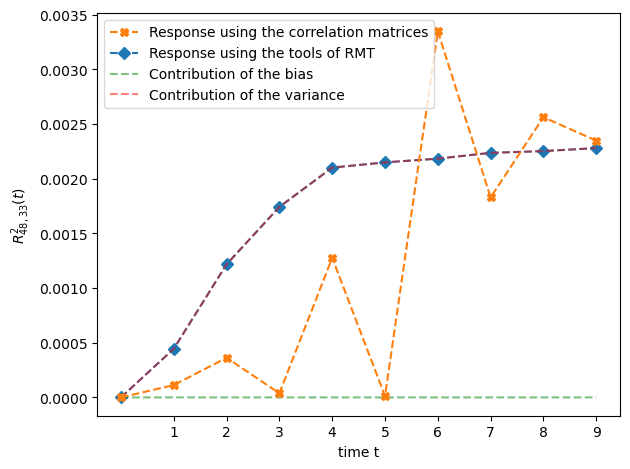

In [254]:
i = 98
j = 83
i = np.random.randint(0, d)
j = np.random.randint(0, d)
plotcomparisons(RTrmt, bias, variance, RTcorr**2,time,  beta, d, i, j)
plt.tight_layout()
#plt.savefig(f'link from {j} to {i} with D={d}, N={taverage}, average connectivity ={Nedges}')
plt.show()


In [282]:
#To check, one can find the true edges present on the graph and then use the label to check in the plot for the response found in the two different ways.
def checkforedges(R,d):
    listedges = [[],[]]
    for i in range(d):
        for j in range(d):
            if R[i,j] != 0:
                if i !=j :
                    listedges[0].append(i)
                    listedges[1].append(j)
    return(listedges)

def checkforedges_one_node(R, i, d):
    listedges = []
    for j in range(d):
            if R[i,j] != 0:
                listedges.append(j)
    return(listedges)

a = checkforedges(np.linalg.matrix_power(R, 1),d )
index = 1
print(a[0][index], a[1][index])

2 56


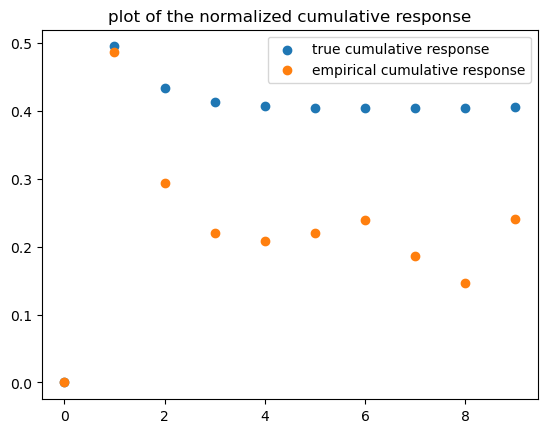

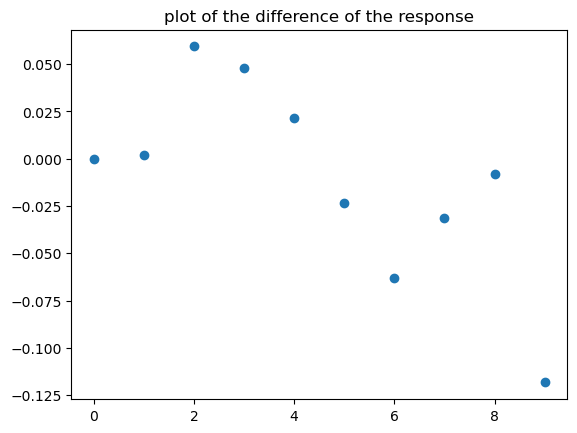

TypeError: cumulative_response_by_node() missing 1 required positional argument: 'Nedges'

In [283]:
#Now, let us average over the whole graph, that is compute the response from all nodes to the others. In the first case, we'll do it only when a true causal link is present while in the second time, we will average over the whole response matrix. This should smoothen out the noise.

def cumulative_response(R, RTcorr, RTrmt, time, d, beta, Nedges, goodlinks = "true"):
    smallR = newR(R,d,beta)
    RTthcumulative = np.zeros((beta * time))
    RTthcumulativebis = np.zeros((beta * time))
    RTcorrcumulative = np.zeros((beta * time))
    listofedges = np.zeros((beta * time,), dtype= object)
    Rpower = power(smallR,beta * time,d)
    if goodlinks =="true" :
        for t in range(1,beta * time):
            listofedges[t] = checkforedges(Rpower[t],d)
            for i in range(len(listofedges[t][0])):
                RTcorrcumulative[t] += RTcorr[t,listofedges[t][0][i], listofedges[t][1][i]]
                RTthcumulative[t] += Rpower[t][listofedges[t][0][i],listofedges[t][1][i]]
    else:
        for t in range(1,beta * time):
            for i in range(d):
                for j in range(d):
                    RTthcumulativebis[t] += RTrmt[t,i,j]
                    RTcorrcumulative[t] += RTcorr[t,i,j]
                    RTthcumulative[t] += Rpower[t][i,j]
    RTcorrcumulative = RTcorrcumulative / (Nedges * d)
    RTthcumulative = RTthcumulative / (Nedges * d)
    RTthcumulativebis = RTthcumulativebis / (Nedges * d)
    return(RTthcumulative, RTthcumulativebis, RTcorrcumulative)

Rtcum, Rtcumbis, Rtcorrcum = cumulative_response(R, RTcorr, RTrmt, time,d, beta, Nedges, goodlinks = "false")
   
xrange = np.arange(0, time, 1/beta)
plt.scatter(xrange,Rtcumbis, label = "true cumulative response") 
plt.scatter(xrange,Rtcorrcum, label = "empirical cumulative response")
plt.title("plot of the normalized cumulative response")
plt.legend()
plt.show()
plt.scatter(xrange, Rtcum-Rtcorrcum)
plt.title("plot of the difference of the response")
plt.show()

#The true cumulative response is a limit curve that can be attained by the empirical response only in the case where you have an infinite amount of measures.

#Let us check the response from one node to all of the others.

def cumulative_response_by_node(R, RTcorr, RTrmt, time, d, beta, Nedges, goodlinks = "false"):
    smallR = newR(R,d,beta)
    RTthcumulative = np.zeros((beta * time, d))
    RTcorrcumulative = np.zeros((beta * time, d))
    listofedges = np.zeros((beta * time,), dtype= object)
    Rpower = power(smallR,beta * time,d)
    if goodlinks =="true" :
        for i in range(d):
            for t in range(1,beta * time):
                listofedges[t] = checkforedges_one_node(Rpower[t], i, d)
                for j in range(len(listofedges[t])):
                    RTcorrcumulative[t,i] += RTcorr[t,i, listofedges[t][j]]
                    RTthcumulative[t,i] += Rpower[t][i,listofedges[t][j]]
    else:
        for t in range(1,beta * time):
            for i in range(d):
                for j in range(d):
                    RTcorrcumulative[t,i] += RTcorr[t,i,j]
                    RTthcumulative[t,i] += Rpower[t][i,j]
    RTcorrcumulative = RTcorrcumulative / (Nedges * d)
    RTthcumulative = RTthcumulative / (Nedges * d)
    return(RTthcumulative, RTcorrcumulative)

Rtcum, Rtcorrcum = cumulative_response_by_node(R, RTcorr, time,d, beta, Nedges, goodlinks = "true")
   
i = 3
xrange = np.arange(0, time, 1/beta)
plt.scatter(xrange,Rtcum[:,i], label = "RMT cumulative response") 
plt.scatter(xrange,Rtcorrcum[:,i], label = "empirical cumulative response")
plt.title(f"plot of the normalized cumulative response for node {i}")
plt.legend()
plt.show()
plt.title("plot of the difference of the response for every nodes")
plt.plot(xrange, Rtcum-Rtcorrcum)

In [ ]:
#Different plotting schemes :

#Construction of plot of the renormalized alpha as a function of rho for a certain population matrix
def plotrenormalizedalpha(Cth, Nmeasures, alpha): 
    selfenergy = np.zeros((Nmeasures,1))
    ratio = np.zeros((Nmeasures,1))
    h_new = np.zeros((Nmeasures,1))
    rho = np.linspace(10**-1, 10**1, Nmeasures)    
    for i in range(0,Nmeasures):
        selfenergy[i], h_new[i] = fixed_point_iteration(Cth[0],rho[i], alpha, initial_guess = alpha/10000, tol=1e-15, max_iter=10000)
    ratio = selfenergy/alpha
    plt.scatter(rho,ratio[:,0], marker ="X")
    plt.xlabel('rho')
    plt.ylabel('ratio selfenergy/alpha')
    plt.xscale('log')
    plt.show()
        
#plotrenormalizedalpha(Cth,10000,alpha)

# construction of plots than can be put in an article

def response_image(RTrmt,bias, variance, RTcorr, d, taverage, Nedges, i, j):
    plotcomparisons(RTrmt, bias, variance, RTcorr**2, d, i, j)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.legend()
    #plt.savefig(f'link from {j} to {i} with D={d}, N={taverage}, average connectivity ={Nedges}.pdf', format = 'pdf')
    plt.show()
    
#response_image(RTrmt, bias, variance, RTcorr, d, taverage, Nedges, i, j)

# construction of plots of the EV of the correlation matrix

def diagonalization(Ct):
    eigen = np.linalg.eigvals(Ct)
    print(len(eigen))
    plt.hist(eigen, bins=300, density ="true",edgecolor='black', alpha = 0.5, label = "empirical histogram of eigenvalues")
    plt.xlabel('Eigenvalue')


#Construction of the MP plot   

def marchenko_pastur_distribution(rho, var = 1, num_points=1000):
    # Calculate the support of the distribution
    lambda_min = var**2 * (1 - np.sqrt(rho))**2
    lambda_max = var**2 * (1 + np.sqrt(rho))**2

    # Generate the lambda values
    lambdas = np.linspace(lambda_min, lambda_max, num_points)

    # Calculate the Marchenko-Pastur density
    density = (1 / (2 * np.pi * rho * var**2 * lambdas)) * np.sqrt((lambda_max - lambdas) * (lambdas - lambda_min))
    density = np.nan_to_num(density)  # Handle any NaNs resulting from sqrt of negative numbers

    # Plot the distribution
    plt.plot(lambdas, density, label="Marchenko-Pastur distribution", color='r')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.ylim(0,5)
    plt.xlim(0, 10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.show()

    #plt.savefig('plot of eigenvalues for d = 1000.pdf', format = 'pdf')
rho = Neff/d
print(1/rho)
diagonalization(Cth[0])
marchenko_pastur_distribution(1/rho)
    

In [ ]:
# We see that the plots of EV of the correlation matrix do not fit with the MP one. This means we have a lot of signal inside the empirical CM. We want to compare whether or not the empirical plot of eigenvalue for the correlation matrix fits with some theoretical one based on RMT.

def fixed_point_iteration_corr_matrix(rho, alpha, C0, eigenvalues, a,b, maxiter = 10**4, tol = 10**-12):
    damp = 0.5 #put damping for convergence
    hr_new, hr_old = 10, 0
    hi_new, hi_old = 10, 0
    # h(\rho, \alpha, z) = 1/rho \int \nu_\infty (dx) x (-z +x/(1+ h(\rho, \alpha, z )))^{-1}, z = a+ib
    for niter in range(0, maxiter):
        hr_old = (1-damp) * hr_old + damp *hr_new
        hi_old = (1-damp ) * hi_old + damp * hi_new
        norm = (1+hr_old)**2 + hi_old **2
        hr_new = 0
        hi_new = 0
        for eigenvalue in eigenvalues :
            U = -a * norm + eigenvalue * (1+hr_old)
            #print(a)
            V = - b * norm - eigenvalue * hi_old
            NORM = U**2 + V**2
            hr_new += 1/(rho * len(eigenvalues) * NORM) * eigenvalue * norm * U
            hi_new += - 1/(rho * len(eigenvalues) * NORM) * eigenvalue * norm * V
        if abs(hr_new - hr_old) <tol and abs(hi_new -hi_old) < tol :
            print("convergence achieved after", niter, "iterations")
            print("hr_new=", hr_new, "hi_new=", hi_new)
            return(hr_new,hr_old)
        if niter == maxiter -1 :
            print("no convergence attained")
    
def compute_stieltjes(x, hr, hi, rho, alpha, C0, eigenvalues, a, b):
    # g(x, \rho, \alpha, z) = (-z + x /(1+h(\rho, \alpha, z ))) ^{-1} 
    
    norm = (1+hr)**2 + hi**2
    U = - a * norm + x * (1+hr)
    #print(U)
    V = -b * norm - x * hi
    NORM = U**2 + V**2
    gxr = norm * U / NORM 
    gxi = - norm * V / NORM
    return (gxr, gxi)

def compute_stieltjes_integral (rho, alpha,C0, eigenvalues,a , b, nmeasures):
    gr = 0
    gi = 0
    
    hr, hi = fixed_point_iteration_corr_matrix(rho, alpha, C0, eigenvalues, a, b)
    # g(\rho, \alpha, z) = \int \nu_\infty (dx) g(x, \rho, \alpha, z)
    
    for eigenvalue in eigenvalues:
        gxr, gxi = compute_stieltjes(eigenvalue, hr, hi, rho, alpha, C0, eigenvalues, a, b)
        gr += 1/len(eigenvalues) * gxr
        gi += 1/len(eigenvalues) * gxi
    #g(\rho, \alpha, z) = - lim_{N,D \to \infty, N/D \to \rho} 1/D Tr( G_\alpha ^{N})
    gr = - gr 
    gi = -gi
    print(gi)
    return(gr,gi)

#compute the inverse Stieltjes transform
def inverse_stieltjes(rho, alpha, C0, b = 10**4, nmeasures = 50):
    # first, we rescale C0 so that G is the resolvent, all the formulas after do not contain alpha anymore
    C0 = - alpha * C0
    eigenvalues = np.linalg.eigvals(C0)
    lambdamax = min(eigenvalues)
    cumulative_p = np.zeros((nmeasures))
    cumulative_p[0] = 0
    a = np.linspace (lambdamax, 0, nmeasures)
    for i in range(1,nmeasures):
        gr, gi = compute_stieltjes_integral (rho, alpha,C0, eigenvalues, a[i], b, nmeasures)
        cumulative_p[i] = cumulative_p[i-1] + 1/np.pi * gi
    print(a)
    plt.plot(- 1/alpha *a, -1/alpha * cumulative_p)
    
inverse_stieltjes(rho,alpha,Cth[0])
    
    


In [ ]:
def projection(C0th, R, time, d, beta):
    #G = \sum_a ca ua uat
    #AtA = \sum_a \lambda_a va vat
    # proj of eigenvecs of AtA on basis of G : vat * ub. This is done for every a,b  
    smallR = newR(R,d, beta)
    Rsumpower, Rlistpower = sumpower(smallR,beta * time,d)
    eigvalC0, eigvecC0 = np.linalg.eig(C0th)
    #print(eigvecC0[2])
    #print(np.linalg.norm(eigvecC0[2]))
    eigvalAtA, eigvecAtA = np.linalg.eig(np.transpose(Rlistpower[1]) @ Rlistpower[1])
    proj = np.zeros((len(eigvecC0),len(eigvecC0)))
    for i in range(len(eigvecC0)):
        for j in range(len(eigvecC0)):
            proj[i,j] = np.dot( np.real(eigvecAtA[j]), np.real(eigvecC0[i]))
            if proj[i,j] >10**-1 :
                
                print(f"{i},{j}",proj[i,j])
    return(proj)

projec = projection(Cth[0], R, time, d, beta)
print(projec)